In [1]:
import pandas as pd
import torch
import numpy as np

# LRAP. Instance-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LRAP(preds, labels):
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = (scores.sum(-1) / labels.sum(-1)).mean()
    return score.item()

# label-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LWLRAP(preds, labels):
    preds = preds.to('cpu')
    labels = labels.to('cpu')

    labels[labels > 0.0] = 1.0  # label smoothingする場合もスコア計算のため1にしてしまう
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    # Number of GT labels per instance
    # num_labels = labels.sum(-1)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = scores.sum() / labels.sum()
    return score.item()

In [2]:

input_dir = "../oof/"
oof0 = pd.read_csv(input_dir + "fold0_oof.csv")
oof1 = pd.read_csv(input_dir + "fold1_oof.csv")
oof2 = pd.read_csv(input_dir + "fold2_oof.csv")
oof3 = pd.read_csv(input_dir + "fold3_oof.csv")
oof4 = pd.read_csv(input_dir + "fold4_oof.csv")
oof = pd.concat([oof0, oof1, oof2, oof3, oof4])
oof

,patch,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,0,003b04435,0.000027,0.270522,0.622983,0.627392,0.000309,0.000365,0.000056,0.022097,...,0.000276,0.001570,0.001100,0.000067,0.001500,0.000089,0.000529,0.001367,0.000135,0.000220
1,1,003b04435,0.000023,0.182271,0.651638,0.673475,0.000436,0.000172,0.000026,0.020713,...,0.000159,0.000903,0.000195,0.000045,0.001469,0.000060,0.000343,0.001063,0.000088,0.000137
2,2,003b04435,0.000015,0.213063,0.661511,0.616095,0.000244,0.000034,0.000009,0.003630,...,0.000098,0.001029,0.000166,0.000034,0.000780,0.000019,0.000110,0.000652,0.000057,0.000118
3,3,003b04435,0.000255,0.506664,0.558322,0.596844,0.000481,0.000444,0.000174,0.146112,...,0.001449,0.004511,0.005918,0.000201,0.002896,0.000178,0.001596,0.002506,0.000643,0.000683
4,4,003b04435,0.000148,0.538084,0.570766,0.443414,0.000280,0.000302,0.000202,0.115213,...,0.000812,0.003047,0.004745,0.000150,0.001825,0.000185,0.001067,0.001169,0.000515,0.000474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7555,3,fffb79246,0.000199,0.000853,0.000321,0.007089,0.000213,0.010418,0.000080,0.001356,...,0.001174,0.005020,0.000190,0.000564,0.001724,0.000130,0.012039,0.000190,0.000175,0.046314
7556,4,fffb79246,0.000121,0.001158,0.000286,0.010863,0.000130,0.003314,0.000080,0.001344,...,0.001671,0.004261,0.000208,0.000373,0.001240,0.000109,0.005310,0.000280,0.000107,0.008194
7557,5,fffb79246,0.000389,0.001278,0.000857,0.021448,0.000240,0.004951,0.000071,0.000790,...,0.002580,0.004772,0.000214,0.001115,0.025503,0.000274,0.004152,0.000999,0.000168,0.008304
7558,6,fffb79246,0.000127,0.000616,0.002451,0.062259,0.000586,0.002394,0.000253,0.002165,...,0.042460,0.004035,0.000177,0.003164,0.006007,0.001819,0.007306,0.201184,0.000283,0.005162


In [3]:
oof2 = oof.groupby('recording_id').max().reset_index(drop=False)
oof2

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,00204008d,7,0.001576,0.000695,0.006808,0.384437,0.000336,0.004754,0.000233,0.001266,...,0.001104,0.000658,0.001689,0.000351,0.689062,0.045835,0.000772,0.001393,0.000144,0.011171
1,003b04435,7,0.000255,0.538084,0.661511,0.673475,0.000638,0.000534,0.000250,0.146112,...,0.002861,0.005864,0.007009,0.000261,0.002896,0.000280,0.001596,0.003669,0.000750,0.001064
2,003bec244,7,0.001337,0.399361,0.007870,0.697515,0.000299,0.123833,0.004989,0.647310,...,0.416386,0.014861,0.006914,0.003942,0.002298,0.000662,0.245292,0.001113,0.001986,0.602273
3,005f1f9a5,7,0.002103,0.481739,0.003703,0.716628,0.002796,0.004302,0.000980,0.643772,...,0.028704,0.010836,0.005597,0.004309,0.012252,0.099821,0.004161,0.075093,0.000520,0.003150
4,006ab765f,7,0.000229,0.006698,0.001919,0.057583,0.000320,0.009276,0.000816,0.320288,...,0.000780,0.010279,0.000494,0.001684,0.000480,0.000335,0.041790,0.000318,0.000248,0.781911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4722,ffc6031f8,7,0.001269,0.005593,0.001121,0.849625,0.000761,0.000750,0.002601,0.598723,...,0.006778,0.825292,0.044763,0.002726,0.011247,0.000142,0.017708,0.003022,0.000354,0.002555
4723,ffd88cd84,7,0.571551,0.623111,0.005149,0.631776,0.001425,0.005169,0.005718,0.017767,...,0.100839,0.800761,0.001975,0.003038,0.416745,0.001741,0.001933,0.004679,0.000545,0.057684
4724,ffebe7313,7,0.005711,0.008463,0.005014,0.395713,0.469141,0.002689,0.000738,0.027031,...,0.048695,0.005342,0.002525,0.011080,0.039527,0.000690,0.017411,0.587240,0.000833,0.028525
4725,fff163132,7,0.000598,0.003858,0.000370,0.286208,0.000676,0.000207,0.006745,0.000942,...,0.003680,0.000651,0.001949,0.575258,0.013645,0.000074,0.202483,0.003385,0.000468,0.012741


In [4]:
tp = pd.read_csv("../input/rfcx-species-audio-detection/train_tp.csv")
tp_fnames, tp_labels = [], []
for recording_id, df in tp.groupby("recording_id"):
    v = sum([np.eye(24)[i] for i in df["species_id"].tolist()])
    v = (v  == 1).astype(int).tolist()
    tp_fnames.append(recording_id)
    tp_labels.append(v) 

tp2 = pd.DataFrame(tp_labels, columns=[f's{i}' for i in range(24)])
tp2['recording_id'] = tp_fnames
tp2 = tp2.sort_values('recording_id')
tp2


,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s15,s16,s17,s18,s19,s20,s21,s22,s23,recording_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,003bec244
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,006ab765f
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,007f87ba2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0099c367b
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,009b760e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fe8d9ac40
1128,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fea6b438a
1129,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ff2eb9ce5
1130,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ffb8d8391


In [5]:
tp_oof = oof2[oof2['recording_id'].isin(tp2['recording_id'])].reset_index(drop=True).sort_values('recording_id')
tp_oof

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,003bec244,7,0.001337,0.399361,0.007870,0.697515,0.000299,0.123833,0.004989,0.647310,...,0.416386,0.014861,0.006914,0.003942,0.002298,0.000662,0.245292,0.001113,0.001986,0.602273
1,006ab765f,7,0.000229,0.006698,0.001919,0.057583,0.000320,0.009276,0.000816,0.320288,...,0.000780,0.010279,0.000494,0.001684,0.000480,0.000335,0.041790,0.000318,0.000248,0.781911
2,007f87ba2,7,0.007547,0.004303,0.009273,0.666487,0.576814,0.002914,0.000872,0.002463,...,0.001724,0.001585,0.001341,0.000390,0.572993,0.000253,0.000819,0.045245,0.000314,0.004672
3,0099c367b,7,0.002717,0.022471,0.000370,0.372266,0.000272,0.000606,0.033587,0.003645,...,0.002792,0.178560,0.002656,0.267906,0.003442,0.000120,0.104775,0.003839,0.000139,0.012093
4,009b760e6,7,0.000975,0.082125,0.000600,0.081300,0.001375,0.034969,0.005701,0.024289,...,0.002983,0.008405,0.000834,0.001506,0.000946,0.002707,0.014700,0.003575,0.000715,0.383864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,fe8d9ac40,7,0.000330,0.193584,0.005466,0.528331,0.002406,0.014731,0.000212,0.001794,...,0.003015,0.006009,0.527093,0.000367,0.040312,0.014859,0.004678,0.002437,0.000378,0.041218
1128,fea6b438a,7,0.001239,0.010287,0.016409,0.740755,0.525209,0.001822,0.000359,0.004795,...,0.088849,0.001310,0.054818,0.003529,0.021958,0.000326,0.001808,0.606226,0.000254,0.021085
1129,ff2eb9ce5,7,0.611743,0.008660,0.000831,0.661863,0.000853,0.002154,0.000237,0.003694,...,0.004262,0.001535,0.000613,0.000323,0.768182,0.000147,0.000244,0.001286,0.000282,0.023715
1130,ffb8d8391,7,0.047971,0.002464,0.001622,0.797323,0.000234,0.496614,0.000283,0.001789,...,0.058835,0.115298,0.002180,0.007501,0.493216,0.001060,0.000683,0.003873,0.000537,0.047675


In [6]:
pred = tp_oof.loc[:, 's0':'s23'].values
target = tp2.loc[:, 's0':'s23'].values

In [7]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
auc = roc_auc_score(target, pred, average=None)
auc

array([0.98452865, 0.9661183 , 0.99059868, 0.72020333, 0.95173752,
       0.98698706, 0.99632918, 0.93325323, 0.975878  , 0.98698864,
       0.99292743, 0.97081331, 0.95909427, 0.99360444, 0.97850277,
       0.96148061, 0.99087591, 0.98175366, 0.91780037, 0.99385366,
       0.97834241, 0.95885397, 0.99498663, 0.96953422])

<BarContainer object of 24 artists>

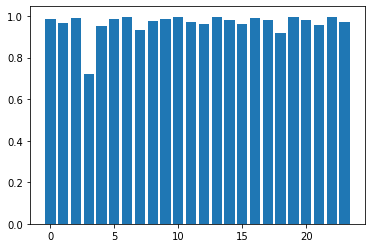

In [8]:
plt.bar(np.arange(24), auc)

In [9]:
pred = torch.tensor(pred)
target = torch.tensor(target)
pred.shape, target.shape

(torch.Size([1132, 24]), torch.Size([1132, 24]))

In [10]:
original_lwlrap = LWLRAP(pred, target)
original_lwlrap

0.7078044414520264